## The metastable states of a peptide in water solution

In [1]:
# import libraries
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
# Download dataset
URL = "https://raw.githubusercontent.com/alexdepremia/Unsupervised-Learning-Datasets/main/high_variance_distances.dat.gz"
compressed_file_name = URL.split('/')[-1]
file_name = compressed_file_name[:-3]
if not os.path.exists('high_variance_distances.dat'):
    os.system(f'wget {URL}')
    os.system(f'gzip -d {compressed_file_name}')
    
# Load dataset
data = np.genfromtxt(file_name, delimiter=' ')

In [3]:
def sorted_spectrum(matrix):
    eigenvalues, left_eigenvectors, right_eigenvectors = linalg.eig(matrix, left=True) # eigenvectors are the columns
    i = np.argsort(-eigenvalues)
    eigenvalues = np.real(eigenvalues[i])
    left_eigenvectors = np.real(left_eigenvectors[:, i])
    right_eigenvectors = np.real(right_eigenvectors[:, i])
    return eigenvalues, left_eigenvectors, right_eigenvectors


def pca(x: np.ndarray, dim: int = 'auto', variance_target: float = 0.99, normalize = False):    
    centered_x = x - np.mean(x, axis=0)
    if normalize:
        centered_x /= np.std(x, axis=0)
    cov = (centered_x.T).dot(centered_x)/len(x)
    evalues, evectors, _ = sorted_spectrum(cov)
    expl_variance = np.cumsum(evalues / np.sum(evalues))
    plt.plot(expl_variance, label = 'Cumulative explained variance')
    if dim=='auto':
        dim = np.sum(expl_variance < variance_target)
        
    
    plt.axvline(x=dim, color = 'red', label = f"Dimensionality reduction: {x.shape[1]} -> {dim}", alpha = 0.8, linestyle='--')
    plt.axhline(y=expl_variance[dim], color = 'gray', label = f"Explained variance: {expl_variance[dim]:.3g}", alpha = 0.8, linestyle='--')
    plt.legend()
    #print(f"Dimensionality reduction: {x.shape[1]} -> {dim}")
    #print(f"Explained variance: {expl_variance[dim]:.3f}")
    return centered_x.dot(evectors[:,:dim])

def show_transition_matrix(M):
    plt.imshow(M)
    if len(M) < 20:
        plt.xticks(np.arange(len(M)))
        plt.yticks(np.arange(len(M)))
    plt.colorbar()
    print(np.round(M, 2))

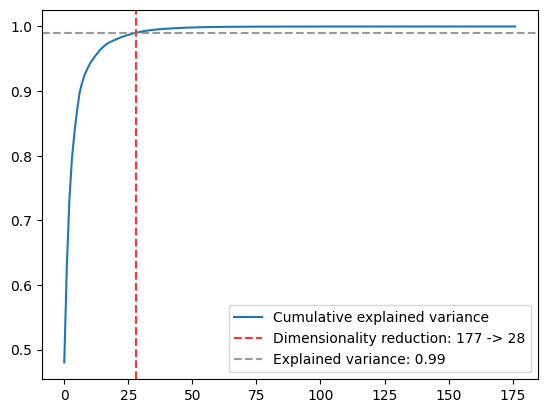

In [4]:
# Preliminary data processing
CENTER = True
NORMALIZE = False
PCA_VARIANCE_TARGET = 0.99

X = data

if CENTER:
    X -= X.mean(axis=0)
if NORMALIZE:
    X /= X.std(axis=0)
if PCA_VARIANCE_TARGET:
    X = pca(X, variance_target = PCA_VARIANCE_TARGET)

### Find the microstates by a cluster analysis performed with k-means or k-medoids.

In [7]:
from sklearn.cluster import KMeans

distance = lambda x, y : np.sum((x-y)**2., axis=-1)

def kmeans(*, X: np.ndarray, k: int):
    centers = X[np.random.choice(np.arange(len(X)), k, replace=True)] # Forgy method
    labels = np.zeros(len(X))
    old_labels = labels - 1
    while np.any(old_labels != labels):
        D = distance(np.expand_dims(X, 1), np.expand_dims(centers, 0))
        old_labels = labels
        labels = np.argmin(D, axis=1)
        centers = np.array([np.mean(X[labels==i], axis=0) for i in range(k)])
    return (labels, centers)

N_CLUSTERS = 5

state, centers = kmeans(X=data, k=N_CLUSTERS)

#kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0, n_init="auto").fit(X)
#state = kmeans.labels_
state -= np.min(state)

### Choose a time lag and estimate the transition matrix between each pair of clusters

In [8]:
TIME_LAG = 1

def get_transition_matrix(states: np.ndarray, time_lag: int) -> np.ndarray:
    frequency_matrix = confusion_matrix(states[:-time_lag], states[time_lag:])
    transition_matrix = frequency_matrix / np.expand_dims(frequency_matrix.sum(axis=1),1)
    np.testing.assert_almost_equal(transition_matrix.sum(axis=1), np.ones(len(transition_matrix)))
    #assert (transition_matrix>0).all()
    return transition_matrix
  
transition_matrix = get_transition_matrix(state, TIME_LAG)

[[0.86 0.06 0.   0.04 0.04]
 [0.08 0.68 0.13 0.06 0.04]
 [0.   0.09 0.83 0.05 0.03]
 [0.08 0.08 0.11 0.72 0.01]
 [0.06 0.06 0.04 0.01 0.83]]


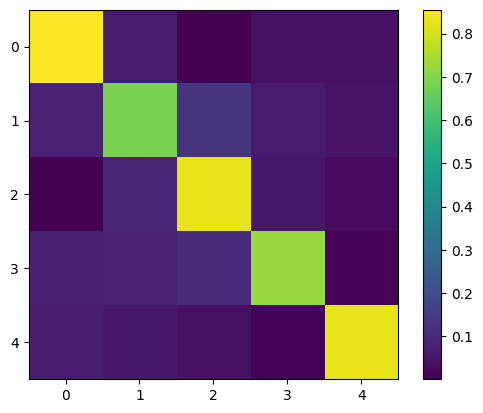

In [9]:
show_transition_matrix(transition_matrix)

### By analyzing the spectrum choose an appropriate number of Markov states. Find the Markov states by inspecting the sign of the eigenvectors.

In [10]:
eigenvalues, left_eigenvectors, right_eigenvectors = sorted_spectrum(transition_matrix)

np.testing.assert_almost_equal(eigenvalues[0], 1)
print(f"{eigenvalues=}")
print(f"{left_eigenvectors=}")
print(f"{right_eigenvectors=}")

stationary_solution = left_eigenvectors[:, 0] / left_eigenvectors[:, 0].sum()
np.testing.assert_allclose(stationary_solution.dot(transition_matrix), stationary_solution)
np.testing.assert_almost_equal((left_eigenvectors.sum(axis=0)[1:])**2, 0.)

eigenvalues=array([1.        , 0.84852288, 0.79669884, 0.66736174, 0.60247736])
left_eigenvectors=array([[-0.5502502 ,  0.69328096, -0.54076749, -0.35527811, -0.20957826],
       [-0.41198839, -0.09723262, -0.04976714, -0.00132325,  0.87373471],
       [-0.57398951, -0.67836719, -0.00620566, -0.52930775, -0.38175302],
       [-0.29369034, -0.11105275, -0.21495517,  0.76012292, -0.2005877 ],
       [-0.33432367,  0.1933716 ,  0.81169546,  0.12578619, -0.08181573]])
right_eigenvectors=array([[-0.4472136 ,  0.6430519 , -0.31877682, -0.20998913, -0.16251963],
       [-0.4472136 , -0.13295267, -0.06753161,  0.02052031,  0.90020369],
       [-0.4472136 , -0.63060421, -0.01111245, -0.33822464, -0.28839468],
       [-0.4472136 , -0.19882449, -0.30492784,  0.91161911, -0.25489702],
       [-0.4472136 ,  0.36278781,  0.89482755,  0.10019062, -0.12278729]])


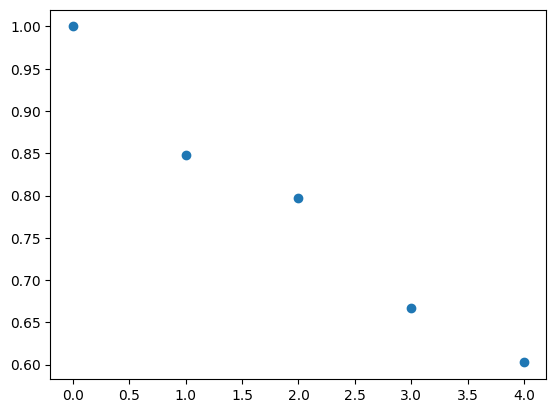

In [11]:
plt.scatter(np.arange(len(eigenvalues)), eigenvalues)

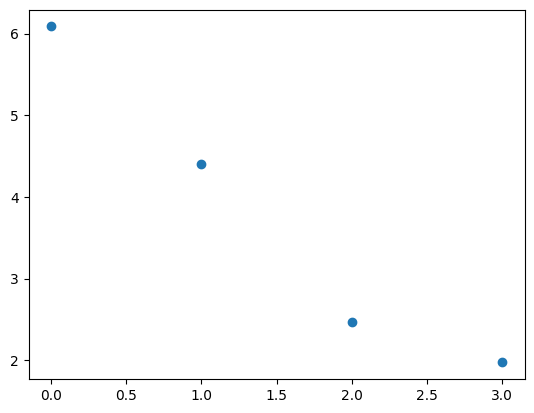

In [12]:
def get_relaxation_time(v, time_lag):
    x = v
    x[x<0] = 1e-99
    return -time_lag/np.log(x)

relaxation_times = get_relaxation_time(eigenvalues[1:], TIME_LAG)
plt.scatter(np.arange(len(relaxation_times)), relaxation_times)

In [13]:
def to_markov_state(states: np.ndarray, left_eigvectors: np.ndarray, level: int =1):
    """
    Crazy one liner:
        - for each eigenvectors extract > 0 information, so turn eigenvetors matrix into binary (1, 0)
        - each row is interpreted as a binary number, so converted to decimal
        - apply modulo (2^level) in order to consider only first level eigenvectors
    """
    markov_states_map = np.sum(2**np.arange(left_eigvectors.shape[1]-1) * (left_eigenvectors[:,1:]>0)*1, axis=1)%(2**level)
    return markov_states_map, markov_states_map[states]

markov_states_map, markov_state = to_markov_state(states=state, left_eigvectors=left_eigenvectors, level=2)

print(f"{markov_states_map = }")
markov_states_dict = {mstate : list(np.arange(len(markov_states_map))[markov_states_map==mstate]) for mstate in np.unique(markov_states_map)}
print(f"{markov_states_dict = }")

markov_states_map = array([1, 0, 0, 0, 3])
markov_states_dict = {0: [1, 2, 3], 1: [0], 3: [4]}


[[0.93 0.05 0.03]
 [0.11 0.86 0.04]
 [0.11 0.06 0.83]]


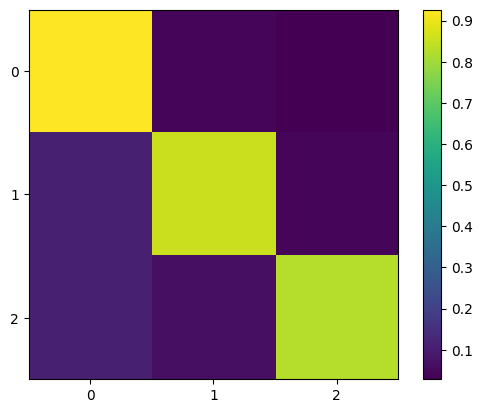

In [14]:
tm = get_transition_matrix(markov_state, time_lag = TIME_LAG)
show_transition_matrix(tm)

### Perform a dimensional reduction with a method of your choice, retaining only two coordinates, and visualize the Markov states in the space of these coordinates.

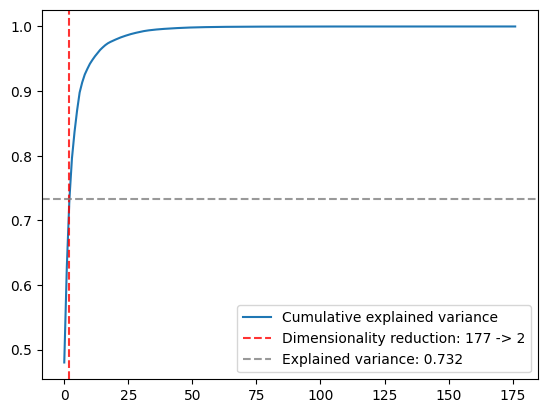

In [15]:
compressed_data = pca(data, dim=2)

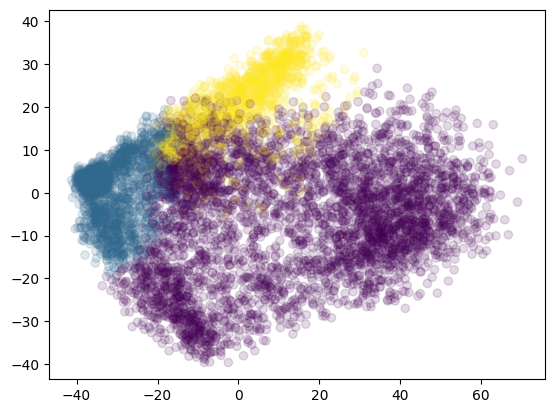

In [16]:
plt.scatter(compressed_data[:,0], compressed_data[:,1], c = markov_state, alpha=0.15, cmap = 'viridis')

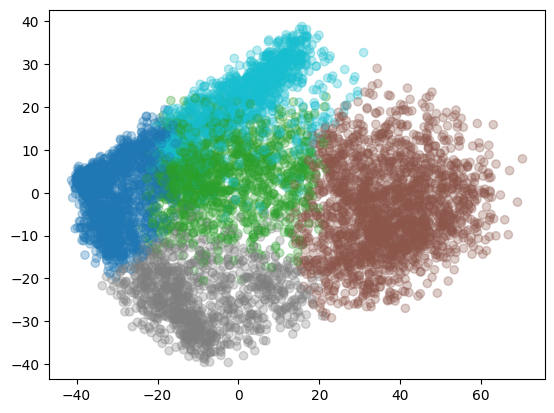

In [17]:
plt.scatter(compressed_data[:,0], compressed_data[:,1], c = state, alpha=0.3, cmap = 'tab10')

### Discuss the stability of the results with respect to the meta-parameters of the approach, in particular, the time lag τ and the number of clusters.

In [44]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

xmin = np.min(compressed_data[:,0])
xmax = np.max(compressed_data[:,0])
ymin = np.min(compressed_data[:,1])
ymax = np.max(compressed_data[:,1])
TAIL = 10

def animate(t):
    plt.cla()
    s = slice(max(t+1-TAIL, 0), t+1)
    points = t+1 - max(t+1-TAIL, 0)

    plt.scatter(compressed_data[s,0], compressed_data[s,1], c = markov_state[s], alpha=1.5**(-np.arange(points)[::-1]), cmap = 'viridis')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

matplotlib.animation.FuncAnimation(fig, animate, frames=np.arange(0, len(data), TIME_LAG))

In [25]:
xmin = np.min(compressed_data[:,0])
xmax = np.max(compressed_data[:,0])
ymin = np.min(compressed_data[:,1])
ymax = np.max(compressed_data[:,1])
TAIL = 10

t = 2

s = slice(max(t+1-TAIL, 0), t+1)
points = t+1 - max(t+1-TAIL, 0)

plt.scatter(compressed_data[s,0], compressed_data[s,1], c = markov_state[s], alpha=1.5**(-np.arange(points)[::-1]), cmap = 'viridis')
#plt.xlim(xmin, xmax)
#plt.ylim(ymin, ymax)

Error in callback <function _draw_all_if_interactive at 0x7f594034f760> (for post_execute):


ValueError: Data array shape, (3,) is incompatible with alpha array shape, (10,). This can occur with the deprecated behavior of the "flat" shading option, in which a row and/or column of the data array is dropped.

ValueError: Data array shape, (3,) is incompatible with alpha array shape, (10,). This can occur with the deprecated behavior of the "flat" shading option, in which a row and/or column of the data array is dropped.

<Figure size 640x480 with 1 Axes>

In [27]:
compressed_data[s,0], compressed_data[s,1]

(array([47.8077447 , 29.58451272, 44.33543456]),
 array([-2.15877553, -1.78942349,  2.97285861]))

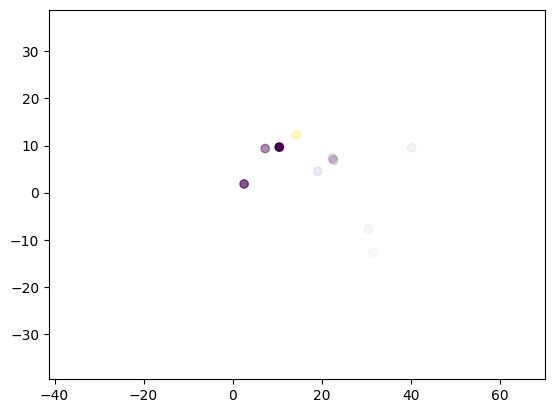

In [38]:
animate(120)